In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np 
from bokeh.plotting import show, figure
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv("Family_Income_and_Expenditure.csv") 

In [3]:
pd.set_option('display.max_columns', 60)
data.head(3)

,Total Household Income,Region,Total Food Expenditure,Main Source of Income,Agricultural Household indicator,Bread and Cereals Expenditure,Total Rice Expenditure,Meat Expenditure,Total Fish and marine products Expenditure,Fruit Expenditure,Vegetables Expenditure,Restaurant and hotels Expenditure,Alcoholic Beverages Expenditure,Tobacco Expenditure,"Clothing, Footwear and Other Wear Expenditure",Housing and water Expenditure,Imputed House Rental Value,Medical Care Expenditure,Transportation Expenditure,Communication Expenditure,Education Expenditure,Miscellaneous Goods and Services Expenditure,Special Occasions Expenditure,Crop Farming and Gardening expenses,Total Income from Entrepreneurial Acitivites,Household Head Sex,Household Head Age,Household Head Marital Status,Household Head Highest Grade Completed,Household Head Job or Business Indicator,Household Head Occupation,Household Head Class of Worker,Type of Household,Total Number of Family members,Members with age less than 5 year old,Members with age 5 - 17 years old,Total number of family members employed,Type of Building/House,Type of Roof,Type of Walls,House Floor Area,House Age,Number of bedrooms,Tenure Status,Toilet Facilities,Electricity,Main Source of Water Supply,Number of Television,Number of CD/VCD/DVD,Number of Component/Stereo set,Number of Refrigerator/Freezer,Number of Washing Machine,Number of Airconditioner,"Number of Car, Jeep, Van",Number of Landline/wireless telephones,Number of Cellular phone,Number of Personal Computer,Number of Stove with Oven/Gas Range,Number of Motorized Banca,Number of Motorcycle/Tricycle
0,480332,CAR,117848,Wage/Salaries,0,42140,38300,24676,16806,3325,13460,3000,0,0,4607,63636,30000,3457,4776,2880,36200,34056,7200,19370,44370,Female,49,Single,Teacher Training and Education Sciences Programs,With Job/Business,General elementary education teaching professi...,Worked for government/government corporation,Extended Family,4,0,1,1,Single house,"Strong material(galvanized,iron,al,tile,concre...",Strong,80,75,3,Own or owner-like possession of house and lot,"Water-sealed, sewer septic tank, used exclusiv...",1,"Own use, faucet, community water system",1,1,0,1,1,0,0,0,2,1,0,0,1
1,198235,CAR,67766,Wage/Salaries,0,17329,13008,17434,11073,2035,7833,2360,960,2132,8230,41370,27000,3520,12900,5700,29300,9150,1500,0,0,Male,40,Married,Transport Services Programs,With Job/Business,Transport conductors,Worked for private establishment,Single Family,3,0,1,2,Single house,"Strong material(galvanized,iron,al,tile,concre...",Strong,42,15,2,Own or owner-like possession of house and lot,"Water-sealed, sewer septic tank, used exclusiv...",1,"Own use, faucet, community water system",1,1,1,0,1,0,0,0,3,1,0,0,2
2,82785,CAR,61609,Wage/Salaries,1,34182,32001,7783,2590,1730,3795,4545,270,4525,2735,14340,7200,70,324,420,425,6450,500,0,0,Male,39,Married,Grade 3,With Job/Business,Farmhands and laborers,Worked for private establishment,Single Family,6,0,4,3,Single house,"Light material (cogon,nipa,anahaw)",Light,35,12,1,Own or owner-like possession of house and lot,"Water-sealed, sewer septic tank, shared with o...",0,"Shared, faucet, community water system",0,0,0,0,0,0,0,0,0,0,0,0,0


# 2. Model 1 - Linear Regression

## 2.1. Model only with numeric data

In [4]:
# spliting data in numeric and text
colnumber = len(data.columns)
data_number = pd.DataFrame()
data_text = pd.DataFrame()
for i in range(colnumber):
    if data.dtypes[i] == "int64":
        data_number[[data.columns[i]]] = pd.DataFrame(data.iloc[:,i])
    else:
        data_text[[data.columns[i]]] = pd.DataFrame(data.iloc[:,i])

### 2.1.2. First Model

#### Without Agricultural Household indicator

In [5]:
# split numeric data in train and test sets
np.random.seed(42)
mask = np.random.rand(data_number.shape[0]) <= 0.7
print('Train set shape {0}, test set shape {1}'.format(data_number[mask].shape, data_number[~mask].shape))

Train set shape (29197, 45), test set shape (12347, 45)


In [6]:
data_number_no = data_number.drop(["Agricultural Household indicator"], axis=1)
mean = data_number_no[mask].mean()
std = data_number_no[mask].std()
# Standard scaler
data_number_scaled = (data_number_no - mean) / std
data_number_scaled.head(3)

,Total Household Income,Total Food Expenditure,Bread and Cereals Expenditure,Total Rice Expenditure,Meat Expenditure,Total Fish and marine products Expenditure,Fruit Expenditure,Vegetables Expenditure,Restaurant and hotels Expenditure,Alcoholic Beverages Expenditure,Tobacco Expenditure,"Clothing, Footwear and Other Wear Expenditure",Housing and water Expenditure,Imputed House Rental Value,Medical Care Expenditure,Transportation Expenditure,Communication Expenditure,Education Expenditure,Miscellaneous Goods and Services Expenditure,Special Occasions Expenditure,Crop Farming and Gardening expenses,Total Income from Entrepreneurial Acitivites,Household Head Age,Total Number of Family members,Members with age less than 5 year old,Members with age 5 - 17 years old,Total number of family members employed,House Floor Area,House Age,Number of bedrooms,Electricity,Number of Television,Number of CD/VCD/DVD,Number of Component/Stereo set,Number of Refrigerator/Freezer,Number of Washing Machine,Number of Airconditioner,"Number of Car, Jeep, Van",Number of Landline/wireless telephones,Number of Cellular phone,Number of Personal Computer,Number of Stove with Oven/Gas Range,Number of Motorized Banca,Number of Motorcycle/Tricycle
0,0.829444,0.636135,1.252872,1.676188,1.357092,0.802257,0.292241,2.556956,-0.523006,-0.495452,-0.567126,-0.044593,0.482977,0.234920,-0.136142,-0.358217,-0.164548,1.304469,1.227468,0.151178,0.112328,-0.068375,-0.171064,-0.274241,-0.586565,-0.255554,-0.235037,0.441310,3.834603,1.091076,0.347999,0.216395,1.008367,-0.416157,1.135635,1.422084,-0.289952,-0.232891,-0.219185,0.060683,0.929406,-0.382383,-0.103874,1.269257
1,-0.174026,-0.335599,-0.571862,-0.431731,0.661341,0.069908,-0.190914,0.853885,-0.549881,-0.058505,-0.044426,0.431058,0.058392,0.157708,-0.133738,0.058085,0.223662,0.990416,-0.190884,-0.283487,-0.283411,-0.354245,-0.809010,-0.713825,-0.586565,-0.255554,0.638707,-0.246175,-0.357021,0.189402,0.347999,0.216395,1.008367,2.160292,-0.738391,1.422084,-0.289952,-0.232891,-0.219185,0.703555,0.929406,-0.382383,-0.103874,3.059869
2,-0.584703,-0.455062,0.667598,1.151209,-0.265847,-1.013735,-0.305149,-0.368259,-0.458127,-0.372561,0.542263,-0.290361,-0.457037,-0.351888,-0.265395,-0.586352,-0.503198,-0.323828,-0.344644,-0.359744,-0.283411,-0.354245,-0.879893,0.604927,-0.586565,1.880751,1.512450,-0.372816,-0.566602,-0.712272,-2.873474,-1.332535,-0.775846,-0.416157,-0.738391,-0.670476,-0.289952,-0.232891,-0.219185,-1.225061,-0.424477,-0.382383,-0.103874,-0.521355


In [7]:
lr = LinearRegression()
lr.fit(data_number_scaled.iloc[mask, 1:], data_number_scaled[mask]["Total Household Income"])
pred = lr.predict(data_number_scaled.iloc[~mask, 1:])
print('RMSE = {0:.04f}'.format(np.sqrt(np.mean((pred - data_number_scaled[~mask]["Total Household Income"])**2))))
# compare
pred = pred * std["Total Household Income"] + mean["Total Household Income"]
print('RMSE = {0:.02f}'.format(np.sqrt(np.mean((pred - data_number_no[~mask]["Total Household Income"])**2))))
# R^2
score = lr.score(data_number_scaled[mask].drop(["Total Household Income"], axis=1),
                 data_number_scaled[mask]["Total Household Income"])
print('R^2 = {0:.04f}'.format(score))

RMSE = 0.5503
RMSE = 154703.51
R^2 = 0.8708


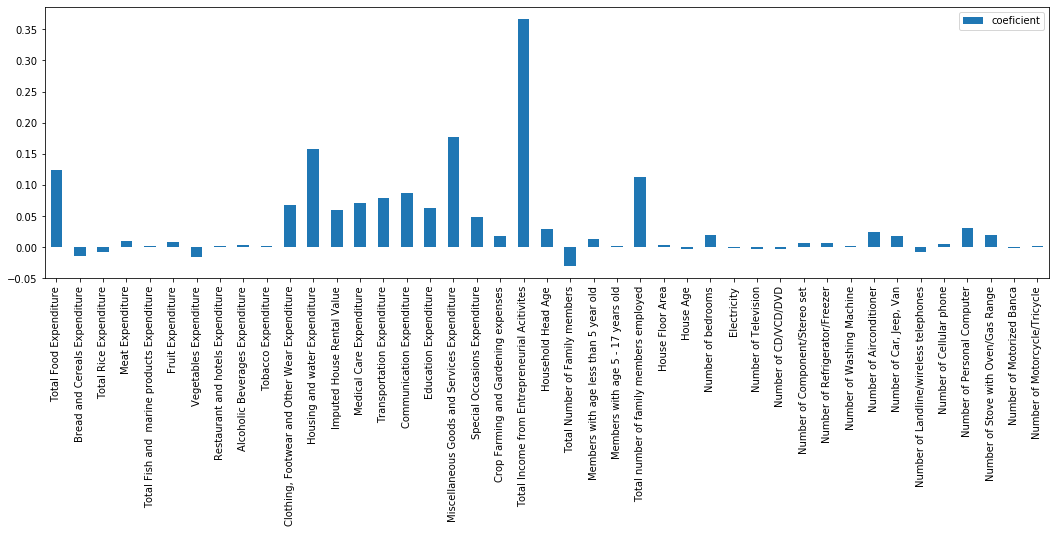

In [8]:
pd.DataFrame(lr.coef_, columns=['coeficient'], 
             index=data_number_scaled[mask].drop(["Total Household Income"], 
                                          axis=1).columns,).plot(kind='bar', figsize=(18,5))

The most important regresion coeficient in this model is "Total Income from Entrepreneurial Acitivites", second one is "Miscellaneous Goods and Services Expenditure"

#### With Agricultural Household indicator

In [9]:
data_number_a = pd.get_dummies(data_number, columns=["Agricultural Household indicator"])
data_number_a.head(3)

,Total Household Income,Total Food Expenditure,Bread and Cereals Expenditure,Total Rice Expenditure,Meat Expenditure,Total Fish and marine products Expenditure,Fruit Expenditure,Vegetables Expenditure,Restaurant and hotels Expenditure,Alcoholic Beverages Expenditure,Tobacco Expenditure,"Clothing, Footwear and Other Wear Expenditure",Housing and water Expenditure,Imputed House Rental Value,Medical Care Expenditure,Transportation Expenditure,Communication Expenditure,Education Expenditure,Miscellaneous Goods and Services Expenditure,Special Occasions Expenditure,Crop Farming and Gardening expenses,Total Income from Entrepreneurial Acitivites,Household Head Age,Total Number of Family members,Members with age less than 5 year old,Members with age 5 - 17 years old,Total number of family members employed,House Floor Area,House Age,Number of bedrooms,Electricity,Number of Television,Number of CD/VCD/DVD,Number of Component/Stereo set,Number of Refrigerator/Freezer,Number of Washing Machine,Number of Airconditioner,"Number of Car, Jeep, Van",Number of Landline/wireless telephones,Number of Cellular phone,Number of Personal Computer,Number of Stove with Oven/Gas Range,Number of Motorized Banca,Number of Motorcycle/Tricycle,Agricultural Household indicator_0,Agricultural Household indicator_1,Agricultural Household indicator_2
0,480332,117848,42140,38300,24676,16806,3325,13460,3000,0,0,4607,63636,30000,3457,4776,2880,36200,34056,7200,19370,44370,49,4,0,1,1,80,75,3,1,1,1,0,1,1,0,0,0,2,1,0,0,1,1,0,0
1,198235,67766,17329,13008,17434,11073,2035,7833,2360,960,2132,8230,41370,27000,3520,12900,5700,29300,9150,1500,0,0,40,3,0,1,2,42,15,2,1,1,1,1,0,1,0,0,0,3,1,0,0,2,1,0,0
2,82785,61609,34182,32001,7783,2590,1730,3795,4545,270,4525,2735,14340,7200,70,324,420,425,6450,500,0,0,39,6,0,4,3,35,12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [10]:
# split numeric data in train and test sets
np.random.seed(42)
mask = np.random.rand(data_number_a.shape[0]) <= 0.7
print('Train set shape {0}, test set shape {1}'.format(data_number_a[mask].shape, data_number_a[~mask].shape))

Train set shape (29197, 47), test set shape (12347, 47)


In [11]:
mean = data_number_a[mask].mean()
std = data_number_a[mask].std()
# Standard scaler
data_number_a_scaled = (data_number_a - mean) / std
data_number_a_scaled.head(3)

,Total Household Income,Total Food Expenditure,Bread and Cereals Expenditure,Total Rice Expenditure,Meat Expenditure,Total Fish and marine products Expenditure,Fruit Expenditure,Vegetables Expenditure,Restaurant and hotels Expenditure,Alcoholic Beverages Expenditure,Tobacco Expenditure,"Clothing, Footwear and Other Wear Expenditure",Housing and water Expenditure,Imputed House Rental Value,Medical Care Expenditure,Transportation Expenditure,Communication Expenditure,Education Expenditure,Miscellaneous Goods and Services Expenditure,Special Occasions Expenditure,Crop Farming and Gardening expenses,Total Income from Entrepreneurial Acitivites,Household Head Age,Total Number of Family members,Members with age less than 5 year old,Members with age 5 - 17 years old,Total number of family members employed,House Floor Area,House Age,Number of bedrooms,Electricity,Number of Television,Number of CD/VCD/DVD,Number of Component/Stereo set,Number of Refrigerator/Freezer,Number of Washing Machine,Number of Airconditioner,"Number of Car, Jeep, Van",Number of Landline/wireless telephones,Number of Cellular phone,Number of Personal Computer,Number of Stove with Oven/Gas Range,Number of Motorized Banca,Number of Motorcycle/Tricycle,Agricultural Household indicator_0,Agricultural Household indicator_1,Agricultural Household indicator_2
0,0.829444,0.636135,1.252872,1.676188,1.357092,0.802257,0.292241,2.556956,-0.523006,-0.495452,-0.567126,-0.044593,0.482977,0.234920,-0.136142,-0.358217,-0.164548,1.304469,1.227468,0.151178,0.112328,-0.068375,-0.171064,-0.274241,-0.586565,-0.255554,-0.235037,0.441310,3.834603,1.091076,0.347999,0.216395,1.008367,-0.416157,1.135635,1.422084,-0.289952,-0.232891,-0.219185,0.060683,0.929406,-0.382383,-0.103874,1.269257,0.689438,-0.524852,-0.344712
1,-0.174026,-0.335599,-0.571862,-0.431731,0.661341,0.069908,-0.190914,0.853885,-0.549881,-0.058505,-0.044426,0.431058,0.058392,0.157708,-0.133738,0.058085,0.223662,0.990416,-0.190884,-0.283487,-0.283411,-0.354245,-0.809010,-0.713825,-0.586565,-0.255554,0.638707,-0.246175,-0.357021,0.189402,0.347999,0.216395,1.008367,2.160292,-0.738391,1.422084,-0.289952,-0.232891,-0.219185,0.703555,0.929406,-0.382383,-0.103874,3.059869,0.689438,-0.524852,-0.344712
2,-0.584703,-0.455062,0.667598,1.151209,-0.265847,-1.013735,-0.305149,-0.368259,-0.458127,-0.372561,0.542263,-0.290361,-0.457037,-0.351888,-0.265395,-0.586352,-0.503198,-0.323828,-0.344644,-0.359744,-0.283411,-0.354245,-0.879893,0.604927,-0.586565,1.880751,1.512450,-0.372816,-0.566602,-0.712272,-2.873474,-1.332535,-0.775846,-0.416157,-0.738391,-0.670476,-0.289952,-0.232891,-0.219185,-1.225061,-0.424477,-0.382383,-0.103874,-0.521355,-1.450407,1.905232,-0.344712


In [12]:
lr = LinearRegression()
lr.fit(data_number_a_scaled.iloc[mask, 1:], data_number_a_scaled[mask]["Total Household Income"])
pred = lr.predict(data_number_a_scaled.iloc[~mask, 1:])
print('RMSE = {0:.04f}'.format(np.sqrt(np.mean((pred - data_number_a_scaled[~mask]["Total Household Income"])**2))))
# compare
pred = pred * std["Total Household Income"] + mean["Total Household Income"]
print('RMSE = {0:.02f}'.format(np.sqrt(np.mean((pred - data_number_a[~mask]["Total Household Income"])**2))))
# R^2
score = lr.score(data_number_a_scaled[mask].drop(["Total Household Income"], axis=1),
                 data_number_a_scaled[mask]["Total Household Income"])
print('R^2 = {0:.04f}'.format(score))

RMSE = 0.5495
RMSE = 154464.51
R^2 = 0.8715


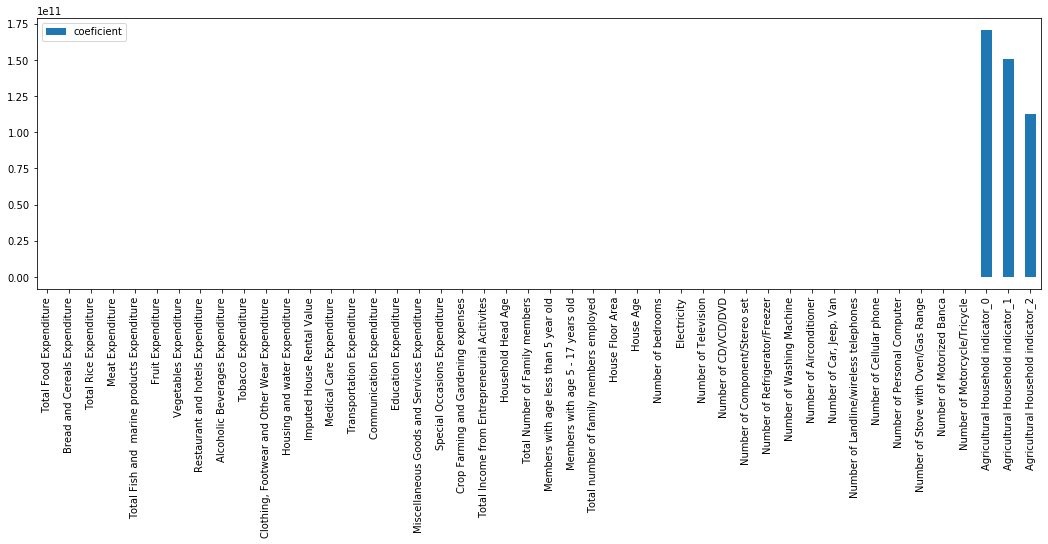

In [13]:
pd.DataFrame(lr.coef_, columns=['coeficient'], 
             index=data_number_a_scaled[mask].drop(["Total Household Income"], 
                                          axis=1).columns,).plot(kind='bar', figsize=(18,5))

Now I get that the most important column is "Agricultural Household indicator" (RMSE = 0.5495).

### 2.1.3. Second Model (with calculated new variables)

### Making new variables

**Transformations that could help improve model:**

   +  count sum of things which in data set start with “Number of ...” (for example: “Number of Television”, “Number of CD/VCD/DVD” and so on.);
   + sum all expenses (“Total Expenditure”);
   + sum just other expenses, excluding food expenses (“Other Expenditure”);
   + sum all food expenses “Food Expenditure”;
   + calculate ratio between “Food Expenditure” and “Total Expenditure”;
   + calculate ratio between “Other Expenditure” and “Total Expenditure”;
   + calculate ratio between “Total Number of Family members” and “Number of bedrooms”;

In [18]:
data_number2 = pd.DataFrame()
data_number2["Number of (all)"] = data_number.iloc[:, 32:45].sum(axis = 1) + data_number["Number of bedrooms"]
data_number2["Other Expenditure"] = data_number["Restaurant and hotels Expenditure"] + data_number["Tobacco Expenditure"] + data_number["Alcoholic Beverages Expenditure"] + data_number["Clothing, Footwear and Other Wear Expenditure"] + data_number["Housing and water Expenditure"] + data_number.iloc[:,15:22].sum(axis = 1)
data_number2["Food Expenditure"] = data_number.iloc[:, 3:9].sum(axis = 1)
data_number2["Total Expenditure"] = data_number.iloc[:, 3:22].drop("Imputed House Rental Value", axis = 1).sum(axis = 1)
data_number2["Food Ex/Total Ex"] = data_number2["Food Expenditure"] / data_number2["Total Expenditure"]
data_number2["Other Ex/Total Ex"] = data_number2["Other Expenditure"] / data_number2["Total Expenditure"]
#data_number2["Members/Bedroom"] = data_number2["Members/Bedroom"].fillna(0)   # ???
data_number2.head(3)

,Number of (all),Other Expenditure,Food Expenditure,Total Expenditure,Food Ex/Total Ex,Other Ex/Total Ex
0,11,179182,138707,317889,0.436338,0.563662
1,12,117122,68712,185834,0.369749,0.630251
2,1,34604,82081,116685,0.703441,0.296559


In [19]:
data_number3 = pd.DataFrame()
data_number3 = pd.concat([data_number, data_number2], axis = 1)

In [20]:
data_number3 = pd.get_dummies(data_number3, columns=["Agricultural Household indicator"])
data_number3.head(3)

,Total Household Income,Total Food Expenditure,Bread and Cereals Expenditure,Total Rice Expenditure,Meat Expenditure,Total Fish and marine products Expenditure,Fruit Expenditure,Vegetables Expenditure,Restaurant and hotels Expenditure,Alcoholic Beverages Expenditure,Tobacco Expenditure,"Clothing, Footwear and Other Wear Expenditure",Housing and water Expenditure,Imputed House Rental Value,Medical Care Expenditure,Transportation Expenditure,Communication Expenditure,Education Expenditure,Miscellaneous Goods and Services Expenditure,Special Occasions Expenditure,Crop Farming and Gardening expenses,Total Income from Entrepreneurial Acitivites,Household Head Age,Total Number of Family members,Members with age less than 5 year old,Members with age 5 - 17 years old,Total number of family members employed,House Floor Area,House Age,Number of bedrooms,Electricity,Number of Television,Number of CD/VCD/DVD,Number of Component/Stereo set,Number of Refrigerator/Freezer,Number of Washing Machine,Number of Airconditioner,"Number of Car, Jeep, Van",Number of Landline/wireless telephones,Number of Cellular phone,Number of Personal Computer,Number of Stove with Oven/Gas Range,Number of Motorized Banca,Number of Motorcycle/Tricycle,Number of (all),Other Expenditure,Food Expenditure,Total Expenditure,Food Ex/Total Ex,Other Ex/Total Ex,Agricultural Household indicator_0,Agricultural Household indicator_1,Agricultural Household indicator_2
0,480332,117848,42140,38300,24676,16806,3325,13460,3000,0,0,4607,63636,30000,3457,4776,2880,36200,34056,7200,19370,44370,49,4,0,1,1,80,75,3,1,1,1,0,1,1,0,0,0,2,1,0,0,1,11,179182,138707,317889,0.436338,0.563662,1,0,0
1,198235,67766,17329,13008,17434,11073,2035,7833,2360,960,2132,8230,41370,27000,3520,12900,5700,29300,9150,1500,0,0,40,3,0,1,2,42,15,2,1,1,1,1,0,1,0,0,0,3,1,0,0,2,12,117122,68712,185834,0.369749,0.630251,1,0,0
2,82785,61609,34182,32001,7783,2590,1730,3795,4545,270,4525,2735,14340,7200,70,324,420,425,6450,500,0,0,39,6,0,4,3,35,12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,34604,82081,116685,0.703441,0.296559,0,1,0


In [21]:
# split numeric data in train and test sets
np.random.seed(42)
mask = np.random.rand(data_number3.shape[0]) <= 0.7
print('Train set shape {0}, test set shape {1}'.format(data_number3[mask].shape, data_number3[~mask].shape))

Train set shape (29197, 53), test set shape (12347, 53)


In [22]:
mean = data_number3[mask].mean()
std = data_number3[mask].std()
# Standard scaler
data_number3_scaled = (data_number3 - mean) / std
data_number3_scaled.head(3)

In [24]:
lr = LinearRegression()
lr.fit(data_number3_scaled.iloc[mask, 1:], data_number3_scaled[mask]["Total Household Income"])
pred = lr.predict(data_number3_scaled.iloc[~mask, 1:])
print('RMSE = {0:.04f}'.format(np.sqrt(np.mean((pred - data_number3_scaled[~mask]["Total Household Income"])**2))))
# compare
pred = pred * std["Total Household Income"] + mean["Total Household Income"]
print('RMSE = {0:.02f}'.format(np.sqrt(np.mean((pred - data_number3[~mask]["Total Household Income"])**2))))
score = lr.score(data_number3_scaled[mask].drop(["Total Household Income"], axis=1),
                 data_number3_scaled[mask]["Total Household Income"])
print('R^2 = {0:.04f}'.format(score))

RMSE = 0.5496
RMSE = 154500.07
R^2 = 0.8718


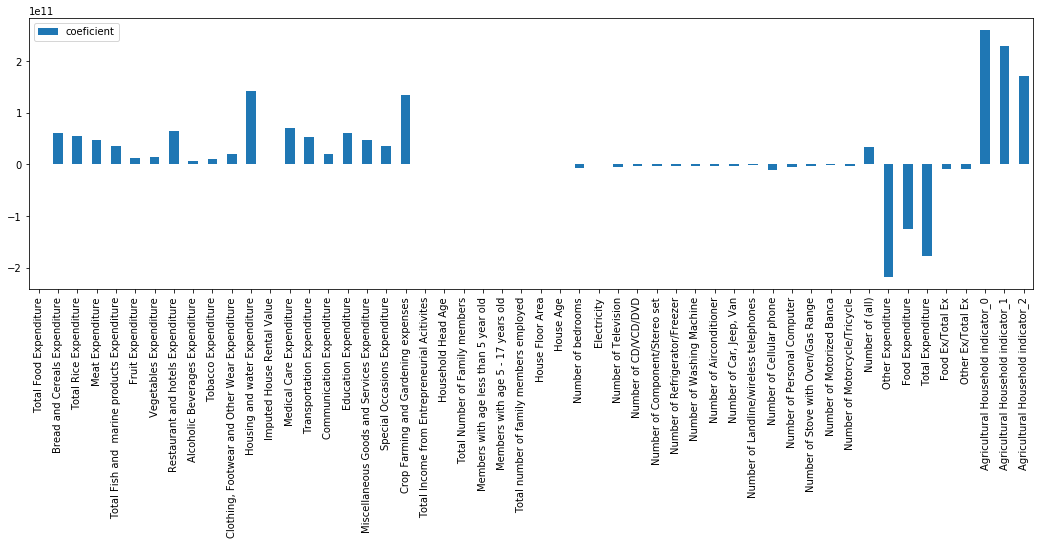

In [25]:
coef_importance = pd.DataFrame(lr.coef_, columns=['coeficient'],index=data_number3_scaled[mask].drop(["Total Household Income"], axis=1).columns)
coef_importance.plot(kind='bar', figsize=(18,5))

#coef_importance.sort_values(by = ["coeficient"]).plot(kind='bar', figsize=(18,5))

Now performance is 0.5496 with new columns. Also other columns have bigger influence than before.

## 2.2. Model with numeric data and some text data   <font color='red'> ()  </font>

In [26]:
data_text_recode = pd.get_dummies(data_text)
data_text_recode.head(3)

,Region_ ARMM,Region_CAR,Region_Caraga,Region_I - Ilocos Region,Region_II - Cagayan Valley,Region_III - Central Luzon,Region_IVA - CALABARZON,Region_IVB - MIMAROPA,Region_IX - Zasmboanga Peninsula,Region_NCR,Region_V - Bicol Region,Region_VI - Western Visayas,Region_VII - Central Visayas,Region_VIII - Eastern Visayas,Region_X - Northern Mindanao,Region_XI - Davao Region,Region_XII - SOCCSKSARGEN,Main Source of Income_Enterpreneurial Activities,Main Source of Income_Other sources of Income,Main Source of Income_Wage/Salaries,Household Head Sex_Female,Household Head Sex_Male,Household Head Marital Status_Annulled,Household Head Marital Status_Divorced/Separated,Household Head Marital Status_Married,Household Head Marital Status_Single,Household Head Marital Status_Unknown,Household Head Marital Status_Widowed,"Household Head Highest Grade Completed_Agriculture, Forestry, and Fishery Programs",Household Head Highest Grade Completed_Architecture and Building Programs,...,Type of Walls_Salvaged,Type of Walls_Strong,Type of Walls_Very Light,Tenure Status_Not Applicable,"Tenure Status_Own house, rent lot","Tenure Status_Own house, rent-free lot with consent of owner","Tenure Status_Own house, rent-free lot without consent of owner",Tenure Status_Own or owner-like possession of house and lot,Tenure Status_Rent house/room including lot,Tenure Status_Rent-free house and lot with consent of owner,Tenure Status_Rent-free house and lot without consent of owner,Toilet Facilities_Closed pit,Toilet Facilities_None,Toilet Facilities_Open pit,Toilet Facilities_Others,"Toilet Facilities_Water-sealed, other depository, shared with other household","Toilet Facilities_Water-sealed, other depository, used exclusively by household","Toilet Facilities_Water-sealed, sewer septic tank, shared with other household","Toilet Facilities_Water-sealed, sewer septic tank, used exclusively by household",Main Source of Water Supply_Dug well,"Main Source of Water Supply_Lake, river, rain and others",Main Source of Water Supply_Others,"Main Source of Water Supply_Own use, faucet, community water system","Main Source of Water Supply_Own use, tubed/piped deep well",Main Source of Water Supply_Peddler,"Main Source of Water Supply_Protected spring, river, stream, etc","Main Source of Water Supply_Shared, faucet, community water system","Main Source of Water Supply_Shared, tubed/piped deep well",Main Source of Water Supply_Tubed/piped shallow well,"Main Source of Water Supply_Unprotected spring, river, stream, etc"
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


Too much covariants. 

For this reason in model with numeric data I will include not all categorical columns, because not every column seems to be very informative for predicting household income. So, I will choose to include this covariants: "Region", "Main source of income", "Household Head Sex", "Household Head Marital Status", "Household Head Class of Worker", "Type of Household".

In [27]:
data_choose = data[["Region", "Main Source of Income", "Household Head Sex", "Household Head Marital Status", 
                         "Household Head Class of Worker", "Type of Household", "Agricultural Household indicator"]]
data_choose_recode = pd.get_dummies(data_choose)
data_number = data_number.drop(["Agricultural Household indicator"], axis=1)

In [28]:
data_total = pd.DataFrame()
data_total = pd.concat([data_number, data_choose_recode], axis = 1)
data_total.head(3)

,Total Household Income,Total Food Expenditure,Bread and Cereals Expenditure,Total Rice Expenditure,Meat Expenditure,Total Fish and marine products Expenditure,Fruit Expenditure,Vegetables Expenditure,Restaurant and hotels Expenditure,Alcoholic Beverages Expenditure,Tobacco Expenditure,"Clothing, Footwear and Other Wear Expenditure",Housing and water Expenditure,Imputed House Rental Value,Medical Care Expenditure,Transportation Expenditure,Communication Expenditure,Education Expenditure,Miscellaneous Goods and Services Expenditure,Special Occasions Expenditure,Crop Farming and Gardening expenses,Total Income from Entrepreneurial Acitivites,Household Head Age,Total Number of Family members,Members with age less than 5 year old,Members with age 5 - 17 years old,Total number of family members employed,House Floor Area,House Age,Number of bedrooms,...,Region_IX - Zasmboanga Peninsula,Region_NCR,Region_V - Bicol Region,Region_VI - Western Visayas,Region_VII - Central Visayas,Region_VIII - Eastern Visayas,Region_X - Northern Mindanao,Region_XI - Davao Region,Region_XII - SOCCSKSARGEN,Main Source of Income_Enterpreneurial Activities,Main Source of Income_Other sources of Income,Main Source of Income_Wage/Salaries,Household Head Sex_Female,Household Head Sex_Male,Household Head Marital Status_Annulled,Household Head Marital Status_Divorced/Separated,Household Head Marital Status_Married,Household Head Marital Status_Single,Household Head Marital Status_Unknown,Household Head Marital Status_Widowed,Household Head Class of Worker_Employer in own family-operated farm or business,Household Head Class of Worker_Self-employed wihout any employee,Household Head Class of Worker_Worked for government/government corporation,Household Head Class of Worker_Worked for private establishment,Household Head Class of Worker_Worked for private household,Household Head Class of Worker_Worked with pay in own family-operated farm or business,Household Head Class of Worker_Worked without pay in own family-operated farm or business,Type of Household_Extended Family,Type of Household_Single Family,Type of Household_Two or More Nonrelated Persons/Members
0,480332,117848,42140,38300,24676,16806,3325,13460,3000,0,0,4607,63636,30000,3457,4776,2880,36200,34056,7200,19370,44370,49,4,0,1,1,80,75,3,...,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
1,198235,67766,17329,13008,17434,11073,2035,7833,2360,960,2132,8230,41370,27000,3520,12900,5700,29300,9150,1500,0,0,40,3,0,1,2,42,15,2,...,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
2,82785,61609,34182,32001,7783,2590,1730,3795,4545,270,4525,2735,14340,7200,70,324,420,425,6450,500,0,0,39,6,0,4,3,35,12,1,...,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0


In [29]:
# split numeric data in train and test sets
np.random.seed(42)
mask = np.random.rand(data_total.shape[0]) <= 0.7
print('Train set shape {0}, test set shape {1}'.format(data_total[mask].shape, data_total[~mask].shape))

Train set shape (29197, 83), test set shape (12347, 83)


In [30]:
mean = data_total[mask].mean()
std = data_total[mask].std()
# Standard scaler
data_total_scaled = (data_total - mean) / std
data_total_scaled.head(3)

,Total Household Income,Total Food Expenditure,Bread and Cereals Expenditure,Total Rice Expenditure,Meat Expenditure,Total Fish and marine products Expenditure,Fruit Expenditure,Vegetables Expenditure,Restaurant and hotels Expenditure,Alcoholic Beverages Expenditure,Tobacco Expenditure,"Clothing, Footwear and Other Wear Expenditure",Housing and water Expenditure,Imputed House Rental Value,Medical Care Expenditure,Transportation Expenditure,Communication Expenditure,Education Expenditure,Miscellaneous Goods and Services Expenditure,Special Occasions Expenditure,Crop Farming and Gardening expenses,Total Income from Entrepreneurial Acitivites,Household Head Age,Total Number of Family members,Members with age less than 5 year old,Members with age 5 - 17 years old,Total number of family members employed,House Floor Area,House Age,Number of bedrooms,...,Region_IX - Zasmboanga Peninsula,Region_NCR,Region_V - Bicol Region,Region_VI - Western Visayas,Region_VII - Central Visayas,Region_VIII - Eastern Visayas,Region_X - Northern Mindanao,Region_XI - Davao Region,Region_XII - SOCCSKSARGEN,Main Source of Income_Enterpreneurial Activities,Main Source of Income_Other sources of Income,Main Source of Income_Wage/Salaries,Household Head Sex_Female,Household Head Sex_Male,Household Head Marital Status_Annulled,Household Head Marital Status_Divorced/Separated,Household Head Marital Status_Married,Household Head Marital Status_Single,Household Head Marital Status_Unknown,Household Head Marital Status_Widowed,Household Head Class of Worker_Employer in own family-operated farm or business,Household Head Class of Worker_Self-employed wihout any employee,Household Head Class of Worker_Worked for government/government corporation,Household Head Class of Worker_Worked for private establishment,Household Head Class of Worker_Worked for private household,Household Head Class of Worker_Worked with pay in own family-operated farm or business,Household Head Class of Worker_Worked without pay in own family-operated farm or business,Type of Household_Extended Family,Type of Household_Single Family,Type of Household_Two or More Nonrelated Persons/Members
0,0.829444,0.636135,1.252872,1.676188,1.357092,0.802257,0.292241,2.556956,-0.523006,-0.495452,-0.567126,-0.044593,0.482977,0.234920,-0.136142,-0.358217,-0.164548,1.304469,1.227468,0.151178,0.112328,-0.068375,-0.171064,-0.274241,-0.586565,-0.255554,-0.235037,0.441310,3.834603,1.091076,...,-0.212983,-0.330358,-0.253192,-0.26891,-0.257453,-0.241734,-0.215606,-0.248875,-0.233612,-0.575587,-0.595207,1.021133,1.888058,-1.888058,-0.013087,-0.189969,-1.748027,4.481091,-0.005852,-0.443055,-0.259865,-0.703374,3.669853,-0.698864,-0.139072,-0.01851,-0.084087,1.490107,-1.475454,-0.065307
1,-0.174026,-0.335599,-0.571862,-0.431731,0.661341,0.069908,-0.190914,0.853885,-0.549881,-0.058505,-0.044426,0.431058,0.058392,0.157708,-0.133738,0.058085,0.223662,0.990416,-0.190884,-0.283487,-0.283411,-0.354245,-0.809010,-0.713825,-0.586565,-0.255554,0.638707,-0.246175,-0.357021,0.189402,...,-0.212983,-0.330358,-0.253192,-0.26891,-0.257453,-0.241734,-0.215606,-0.248875,-0.233612,-0.575587,-0.595207,1.021133,-0.529627,0.529627,-0.013087,-0.189969,0.572054,-0.223152,-0.005852,-0.443055,-0.259865,-0.703374,-0.272481,1.430844,-0.139072,-0.01851,-0.084087,-0.671070,0.677734,-0.065307
2,-0.584703,-0.455062,0.667598,1.151209,-0.265847,-1.013735,-0.305149,-0.368259,-0.458127,-0.372561,0.542263,-0.290361,-0.457037,-0.351888,-0.265395,-0.586352,-0.503198,-0.323828,-0.344644,-0.359744,-0.283411,-0.354245,-0.879893,0.604927,-0.586565,1.880751,1.512450,-0.372816,-0.566602,-0.712272,...,-0.212983,-0.330358,-0.253192,-0.26891,-0.257453,-0.241734,-0.215606,-0.248875,-0.233612,-0.575587,-0.595207,1.021133,-0.529627,0.529627,-0.013087,-0.189969,0.572054,-0.223152,-0.005852,-0.443055,-0.259865,-0.703374,-0.272481,1.430844,-0.139072,-0.01851,-0.084087,-0.671070,0.677734,-0.065307


In [31]:
lr = LinearRegression()
lr.fit(data_total_scaled.iloc[mask, 1:], data_total_scaled[mask]["Total Household Income"])
pred = lr.predict(data_total_scaled.iloc[~mask, 1:])
print('RMSE = {0:.04f}'.format(np.sqrt(np.mean((pred - data_total_scaled[~mask]["Total Household Income"])**2))))
# compare
pred = pred * std["Total Household Income"] + mean["Total Household Income"]
print('RMSE = {0:.02f}'.format(np.sqrt(np.mean((pred - data_total[~mask]["Total Household Income"])**2))))
# R^2
score = lr.score(data_total_scaled[mask].drop(["Total Household Income"], axis=1),
                 data_total_scaled[mask]["Total Household Income"])
print('R^2 = {0:.04f}'.format(score))

RMSE = 0.5421
RMSE = 152404.92
R^2 = 0.8790


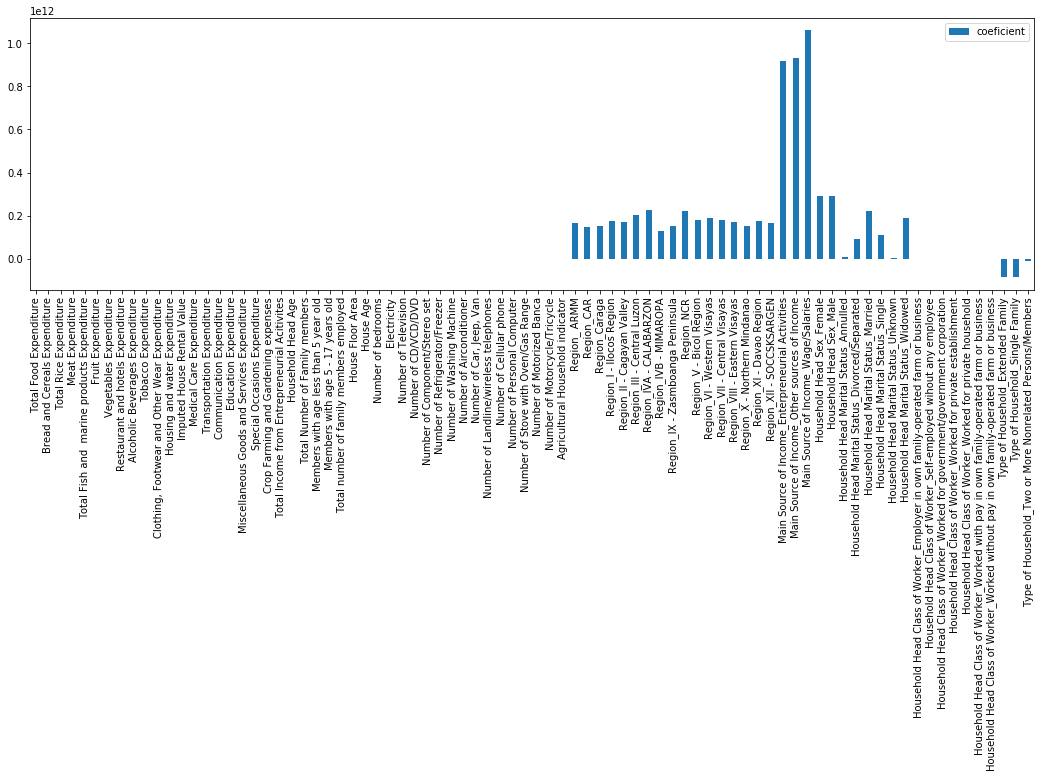

In [32]:
pd.DataFrame(lr.coef_, columns=['coeficient'], 
             index=data_total_scaled[mask].drop(["Total Household Income"], 
                                          axis=1).columns,).plot(kind='bar', figsize=(18,5))

In [33]:
pd.options.display.max_rows = 83
coef_importance = pd.DataFrame(lr.coef_, columns=['coeficient'], index=data_total_scaled[mask].drop(["Total Household Income"],axis=1).columns)
coef_importance.sort_values(by = ["coeficient"], ascending = False)

,coeficient
Main Source of Income_Wage/Salaries,1.060189e+12
Main Source of Income_Other sources of Income,9.321250e+11
Main Source of Income_Enterpreneurial Activities,9.169527e+11
Household Head Sex_Female,2.903022e+11
Household Head Sex_Male,2.903022e+11
Region_IVA - CALABARZON,2.246882e+11
Region_NCR,2.231738e+11
Household Head Marital Status_Married,2.216401e+11
Region_III - Central Luzon,2.018036e+11
Household Head Marital Status_Widowed,1.904505e+11


### drop corelated columns from last model

In [34]:
data_total_scaled.head(3)

,Total Household Income,Total Food Expenditure,Bread and Cereals Expenditure,Total Rice Expenditure,Meat Expenditure,Total Fish and marine products Expenditure,Fruit Expenditure,Vegetables Expenditure,Restaurant and hotels Expenditure,Alcoholic Beverages Expenditure,Tobacco Expenditure,"Clothing, Footwear and Other Wear Expenditure",Housing and water Expenditure,Imputed House Rental Value,Medical Care Expenditure,Transportation Expenditure,Communication Expenditure,Education Expenditure,Miscellaneous Goods and Services Expenditure,Special Occasions Expenditure,Crop Farming and Gardening expenses,Total Income from Entrepreneurial Acitivites,Household Head Age,Total Number of Family members,Members with age less than 5 year old,Members with age 5 - 17 years old,Total number of family members employed,House Floor Area,House Age,Number of bedrooms,...,Region_IX - Zasmboanga Peninsula,Region_NCR,Region_V - Bicol Region,Region_VI - Western Visayas,Region_VII - Central Visayas,Region_VIII - Eastern Visayas,Region_X - Northern Mindanao,Region_XI - Davao Region,Region_XII - SOCCSKSARGEN,Main Source of Income_Enterpreneurial Activities,Main Source of Income_Other sources of Income,Main Source of Income_Wage/Salaries,Household Head Sex_Female,Household Head Sex_Male,Household Head Marital Status_Annulled,Household Head Marital Status_Divorced/Separated,Household Head Marital Status_Married,Household Head Marital Status_Single,Household Head Marital Status_Unknown,Household Head Marital Status_Widowed,Household Head Class of Worker_Employer in own family-operated farm or business,Household Head Class of Worker_Self-employed wihout any employee,Household Head Class of Worker_Worked for government/government corporation,Household Head Class of Worker_Worked for private establishment,Household Head Class of Worker_Worked for private household,Household Head Class of Worker_Worked with pay in own family-operated farm or business,Household Head Class of Worker_Worked without pay in own family-operated farm or business,Type of Household_Extended Family,Type of Household_Single Family,Type of Household_Two or More Nonrelated Persons/Members
0,0.829444,0.636135,1.252872,1.676188,1.357092,0.802257,0.292241,2.556956,-0.523006,-0.495452,-0.567126,-0.044593,0.482977,0.234920,-0.136142,-0.358217,-0.164548,1.304469,1.227468,0.151178,0.112328,-0.068375,-0.171064,-0.274241,-0.586565,-0.255554,-0.235037,0.441310,3.834603,1.091076,...,-0.212983,-0.330358,-0.253192,-0.26891,-0.257453,-0.241734,-0.215606,-0.248875,-0.233612,-0.575587,-0.595207,1.021133,1.888058,-1.888058,-0.013087,-0.189969,-1.748027,4.481091,-0.005852,-0.443055,-0.259865,-0.703374,3.669853,-0.698864,-0.139072,-0.01851,-0.084087,1.490107,-1.475454,-0.065307
1,-0.174026,-0.335599,-0.571862,-0.431731,0.661341,0.069908,-0.190914,0.853885,-0.549881,-0.058505,-0.044426,0.431058,0.058392,0.157708,-0.133738,0.058085,0.223662,0.990416,-0.190884,-0.283487,-0.283411,-0.354245,-0.809010,-0.713825,-0.586565,-0.255554,0.638707,-0.246175,-0.357021,0.189402,...,-0.212983,-0.330358,-0.253192,-0.26891,-0.257453,-0.241734,-0.215606,-0.248875,-0.233612,-0.575587,-0.595207,1.021133,-0.529627,0.529627,-0.013087,-0.189969,0.572054,-0.223152,-0.005852,-0.443055,-0.259865,-0.703374,-0.272481,1.430844,-0.139072,-0.01851,-0.084087,-0.671070,0.677734,-0.065307
2,-0.584703,-0.455062,0.667598,1.151209,-0.265847,-1.013735,-0.305149,-0.368259,-0.458127,-0.372561,0.542263,-0.290361,-0.457037,-0.351888,-0.265395,-0.586352,-0.503198,-0.323828,-0.344644,-0.359744,-0.283411,-0.354245,-0.879893,0.604927,-0.586565,1.880751,1.512450,-0.372816,-0.566602,-0.712272,...,-0.212983,-0.330358,-0.253192,-0.26891,-0.257453,-0.241734,-0.215606,-0.248875,-0.233612,-0.575587,-0.595207,1.021133,-0.529627,0.529627,-0.013087,-0.189969,0.572054,-0.223152,-0.005852,-0.443055,-0.259865,-0.703374,-0.272481,1.430844,-0.139072,-0.01851,-0.084087,-0.671070,0.677734,-0.065307


In [35]:
data_total_scaled = data_total_scaled.drop(["Bread and Cereals Expenditure",
                                            "Housing and water Expenditure", "Total Food Expenditure"], axis=1)

In [36]:
lr = LinearRegression()
lr.fit(data_total_scaled.iloc[mask, 1:], data_total_scaled[mask]["Total Household Income"])
pred = lr.predict(data_total_scaled.iloc[~mask, 1:])
print('RMSE = {0:.04f}'.format(np.sqrt(np.mean((pred - data_total_scaled[~mask]["Total Household Income"])**2))))
# compare
pred = pred * std["Total Household Income"] + mean["Total Household Income"]
print('RMSE = {0:.02f}'.format(np.sqrt(np.mean((pred - data_total[~mask]["Total Household Income"])**2))))
# R^2
score = lr.score(data_total_scaled[mask].drop(["Total Household Income"], axis=1),
                 data_total_scaled[mask]["Total Household Income"])
print('R^2 = {0:.04f}'.format(score))

RMSE = 0.5424
RMSE = 152488.74
R^2 = 0.8759


## TEST

In [40]:
# spliting data in numeric and text
colnumber = len(data.columns)
data_number = pd.DataFrame()
data_text = pd.DataFrame()
for i in range(colnumber):
    if data.dtypes[i] == "int64":
        data_number[[data.columns[i]]] = pd.DataFrame(data.iloc[:,i])
    else:
        data_text[[data.columns[i]]] = pd.DataFrame(data.iloc[:,i])

In [41]:
data_number_new = pd.DataFrame()
data_number_new["Number of (all)"] = data_number.iloc[:, 32:45].sum(axis = 1) + data_number["Number of bedrooms"]
data_number_new["Other Expenditure"] = data_number["Restaurant and hotels Expenditure"] + data_number["Tobacco Expenditure"] + data_number["Alcoholic Beverages Expenditure"] + data_number["Clothing, Footwear and Other Wear Expenditure"] + data_number["Housing and water Expenditure"] + data_number.iloc[:,15:22].sum(axis = 1)
data_number_new["Food Expenditure"] = data_number.iloc[:, 2:9].sum(axis = 1)
data_number_new["Total Expenditure"] = data_number.iloc[:, 2:22].drop("Imputed House Rental Value", axis = 1).sum(axis = 1)
data_number_new["Food Ex/Total Ex"] = data_number_new["Food Expenditure"] / data_number_new["Total Expenditure"]
data_number_new["Other Ex/Total Ex"] = data_number_new["Other Expenditure"] / data_number_new["Total Expenditure"]
#data_number_new["Working members/Total members in family"] = data_number["Total number of family members employed"] / data_number["Total Number of Family members"]
#data_number2["Members/Bedroom"] = data_number2["Members/Bedroom"].fillna(0)   # ???
data_number_new.head(5)

,Number of (all),Other Expenditure,Food Expenditure,Total Expenditure,Food Ex/Total Ex,Other Ex/Total Ex
0,11,179182,138707,317889,0.436338,0.563662
1,12,117122,68712,185834,0.369749,0.630251
2,1,34604,82082,116686,0.703443,0.296557
3,3,52490,92992,145482,0.639199,0.360801
4,9,80777,107342,188119,0.570607,0.429393


In [42]:
data_number_left = pd.DataFrame()
data_choose = pd.DataFrame()

data_number_left = data_number[["Total Household Income", "Agricultural Household indicator", 
                               "Imputed House Rental Value", "Total Income from Entrepreneurial Acitivites", 
                               "Household Head Age", "Total Number of Family members", 
                                "Total number of family members employed", "House Floor Area", "House Age", 
                               "Electricity"]]
data_choose = data[["Region", "Main Source of Income", "Household Head Sex", "Household Head Marital Status", 
                         "Household Head Class of Worker", "Type of Household"]]

data_choose_recode = pd.get_dummies(data_choose)
data_number_left = pd.get_dummies(data_number_left, columns=["Agricultural Household indicator"])
data_number_left.head(3)

,Total Household Income,Imputed House Rental Value,Total Income from Entrepreneurial Acitivites,Household Head Age,Total Number of Family members,Total number of family members employed,House Floor Area,House Age,Electricity,Agricultural Household indicator_0,Agricultural Household indicator_1,Agricultural Household indicator_2
0,480332,30000,44370,49,4,1,80,75,1,1,0,0
1,198235,27000,0,40,3,2,42,15,1,1,0,0
2,82785,7200,0,39,6,3,35,12,0,0,1,0


In [43]:
data_new = pd.DataFrame()
data_new = pd.concat([data_number_left, data_number_new, data_choose_recode], axis = 1)
data_new.head(3)

,Total Household Income,Imputed House Rental Value,Total Income from Entrepreneurial Acitivites,Household Head Age,Total Number of Family members,Total number of family members employed,House Floor Area,House Age,Electricity,Agricultural Household indicator_0,Agricultural Household indicator_1,Agricultural Household indicator_2,Number of (all),Other Expenditure,Food Expenditure,Total Expenditure,Food Ex/Total Ex,Other Ex/Total Ex,Region_ ARMM,Region_CAR,Region_Caraga,Region_I - Ilocos Region,Region_II - Cagayan Valley,Region_III - Central Luzon,Region_IVA - CALABARZON,Region_IVB - MIMAROPA,Region_IX - Zasmboanga Peninsula,Region_NCR,Region_V - Bicol Region,Region_VI - Western Visayas,Region_VII - Central Visayas,Region_VIII - Eastern Visayas,Region_X - Northern Mindanao,Region_XI - Davao Region,Region_XII - SOCCSKSARGEN,Main Source of Income_Enterpreneurial Activities,Main Source of Income_Other sources of Income,Main Source of Income_Wage/Salaries,Household Head Sex_Female,Household Head Sex_Male,Household Head Marital Status_Annulled,Household Head Marital Status_Divorced/Separated,Household Head Marital Status_Married,Household Head Marital Status_Single,Household Head Marital Status_Unknown,Household Head Marital Status_Widowed,Household Head Class of Worker_Employer in own family-operated farm or business,Household Head Class of Worker_Self-employed wihout any employee,Household Head Class of Worker_Worked for government/government corporation,Household Head Class of Worker_Worked for private establishment,Household Head Class of Worker_Worked for private household,Household Head Class of Worker_Worked with pay in own family-operated farm or business,Household Head Class of Worker_Worked without pay in own family-operated farm or business,Type of Household_Extended Family,Type of Household_Single Family,Type of Household_Two or More Nonrelated Persons/Members
0,480332,30000,44370,49,4,1,80,75,1,1,0,0,11,179182,138707,317889,0.436338,0.563662,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
1,198235,27000,0,40,3,2,42,15,1,1,0,0,12,117122,68712,185834,0.369749,0.630251,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
2,82785,7200,0,39,6,3,35,12,0,0,1,0,1,34604,82082,116686,0.703443,0.296557,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0


In [44]:
# split numeric data in train and test sets
np.random.seed(42)
mask = np.random.rand(data_new.shape[0]) <= 0.7
print('Train set shape {0}, test set shape {1}'.format(data_new[mask].shape, data_new[~mask].shape))

Train set shape (29197, 56), test set shape (12347, 56)


In [45]:
mean = data_new[mask].mean()
std = data_new[mask].std()
# Standard scaler
data_new_scaled = (data_new - mean) / std
data_new_scaled.head(3)

,Total Household Income,Imputed House Rental Value,Total Income from Entrepreneurial Acitivites,Household Head Age,Total Number of Family members,Total number of family members employed,House Floor Area,House Age,Electricity,Agricultural Household indicator_0,Agricultural Household indicator_1,Agricultural Household indicator_2,Number of (all),Other Expenditure,Food Expenditure,Total Expenditure,Food Ex/Total Ex,Other Ex/Total Ex,Region_ ARMM,Region_CAR,Region_Caraga,Region_I - Ilocos Region,Region_II - Cagayan Valley,Region_III - Central Luzon,Region_IVA - CALABARZON,Region_IVB - MIMAROPA,Region_IX - Zasmboanga Peninsula,Region_NCR,Region_V - Bicol Region,Region_VI - Western Visayas,Region_VII - Central Visayas,Region_VIII - Eastern Visayas,Region_X - Northern Mindanao,Region_XI - Davao Region,Region_XII - SOCCSKSARGEN,Main Source of Income_Enterpreneurial Activities,Main Source of Income_Other sources of Income,Main Source of Income_Wage/Salaries,Household Head Sex_Female,Household Head Sex_Male,Household Head Marital Status_Annulled,Household Head Marital Status_Divorced/Separated,Household Head Marital Status_Married,Household Head Marital Status_Single,Household Head Marital Status_Unknown,Household Head Marital Status_Widowed,Household Head Class of Worker_Employer in own family-operated farm or business,Household Head Class of Worker_Self-employed wihout any employee,Household Head Class of Worker_Worked for government/government corporation,Household Head Class of Worker_Worked for private establishment,Household Head Class of Worker_Worked for private household,Household Head Class of Worker_Worked with pay in own family-operated farm or business,Household Head Class of Worker_Worked without pay in own family-operated farm or business,Type of Household_Extended Family,Type of Household_Single Family,Type of Household_Two or More Nonrelated Persons/Members
0,0.829444,0.234920,-0.068375,-0.171064,-0.274241,-0.235037,0.441310,3.834603,0.347999,0.689438,-0.524852,-0.344712,0.813113,0.402659,1.818010,0.776749,0.010862,-0.010862,-0.23758,4.817571,-0.212807,-0.248098,-0.238303,-0.292349,-0.333156,-0.176489,-0.212983,-0.330358,-0.253192,-0.26891,-0.257453,-0.241734,-0.215606,-0.248875,-0.233612,-0.575587,-0.595207,1.021133,1.888058,-1.888058,-0.013087,-0.189969,-1.748027,4.481091,-0.005852,-0.443055,-0.259865,-0.703374,3.669853,-0.698864,-0.139072,-0.01851,-0.084087,1.490107,-1.475454,-0.065307
1,-0.174026,0.157708,-0.354245,-0.809010,-0.713825,0.638707,-0.246175,-0.357021,0.347999,0.689438,-0.524852,-0.344712,1.011117,-0.051079,-0.087485,-0.065019,-0.411580,0.411580,-0.23758,4.817571,-0.212807,-0.248098,-0.238303,-0.292349,-0.333156,-0.176489,-0.212983,-0.330358,-0.253192,-0.26891,-0.257453,-0.241734,-0.215606,-0.248875,-0.233612,-0.575587,-0.595207,1.021133,-0.529627,0.529627,-0.013087,-0.189969,0.572054,-0.223152,-0.005852,-0.443055,-0.259865,-0.703374,-0.272481,1.430844,-0.139072,-0.01851,-0.084087,-0.671070,0.677734,-0.065307
2,-0.584703,-0.351888,-0.354245,-0.879893,0.604927,1.512450,-0.372816,-0.566602,-2.873474,-1.450407,1.905232,-0.344712,-1.166925,-0.654392,0.276491,-0.505794,1.705397,-1.705397,-0.23758,4.817571,-0.212807,-0.248098,-0.238303,-0.292349,-0.333156,-0.176489,-0.212983,-0.330358,-0.253192,-0.26891,-0.257453,-0.241734,-0.215606,-0.248875,-0.233612,-0.575587,-0.595207,1.021133,-0.529627,0.529627,-0.013087,-0.189969,0.572054,-0.223152,-0.005852,-0.443055,-0.259865,-0.703374,-0.272481,1.430844,-0.139072,-0.01851,-0.084087,-0.671070,0.677734,-0.065307


In [46]:
lr = LinearRegression()
lr.fit(data_new_scaled.iloc[mask, 1:], data_new_scaled[mask]["Total Household Income"])
pred = lr.predict(data_new_scaled.iloc[~mask, 1:])
print('RMSE = {0:.04f}'.format(np.sqrt(np.mean((pred - data_new_scaled[~mask]["Total Household Income"])**2))))
# compare
pred = pred * std["Total Household Income"] + mean["Total Household Income"]
print('RMSE = {0:.02f}'.format(np.sqrt(np.mean((pred - data_new[~mask]["Total Household Income"])**2))))
# R^2
score = lr.score(data_new_scaled[mask].drop(["Total Household Income"], axis=1),
                 data_new_scaled[mask]["Total Household Income"])
print('R^2 = {0:.04f}'.format(score))

RMSE = 0.5744
RMSE = 161468.71
R^2 = 0.8457


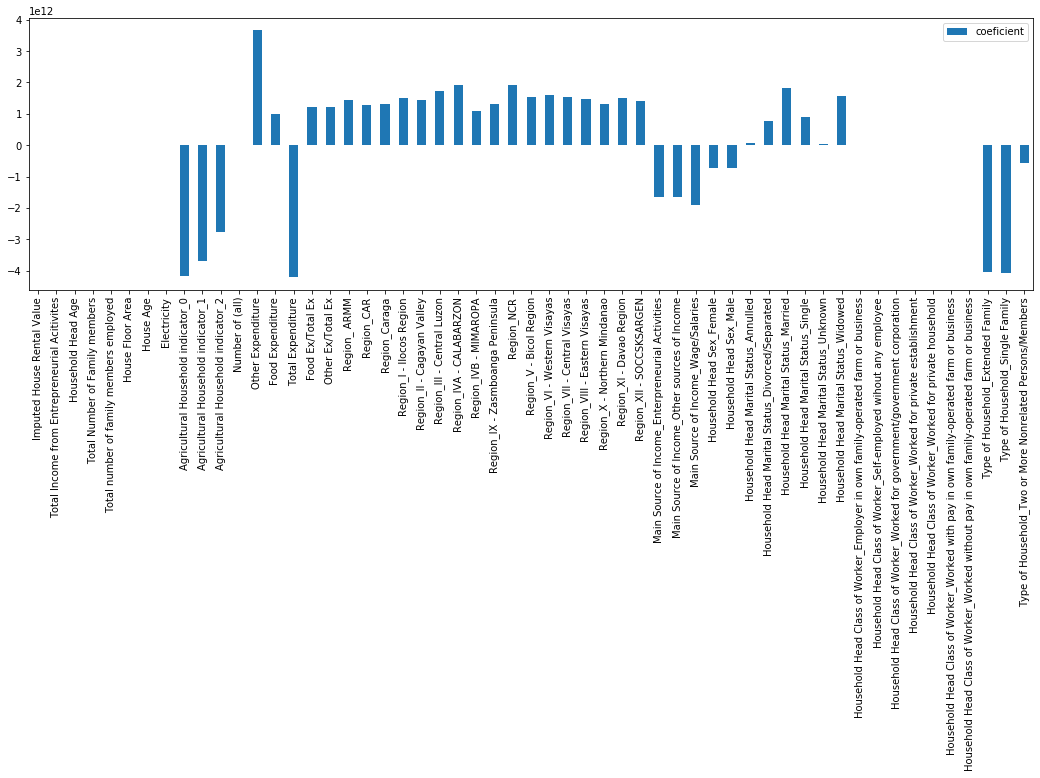

In [47]:
pd.DataFrame(lr.coef_, columns=['coeficient'], 
             index=data_new_scaled[mask].drop(["Total Household Income"], 
                                          axis=1).columns,).plot(kind='bar', figsize=(18,5))

In [48]:
pd.options.display.max_rows = 83
coef_importance = pd.DataFrame(lr.coef_, columns=['coeficient'], index=data_new_scaled[mask].drop(["Total Household Income"],axis=1).columns)
coef_importance.sort_values(by = ["coeficient"], ascending = False)

,coeficient
Other Expenditure,3.667977e+12
Region_IVA - CALABARZON,1.920836e+12
Region_NCR,1.907889e+12
Household Head Marital Status_Married,1.837294e+12
Region_III - Central Luzon,1.725198e+12
Region_VI - Western Visayas,1.606350e+12
Household Head Marital Status_Widowed,1.578746e+12
Region_VII - Central Visayas,1.546608e+12
Region_V - Bicol Region,1.524118e+12
Region_XI - Davao Region,1.501190e+12
